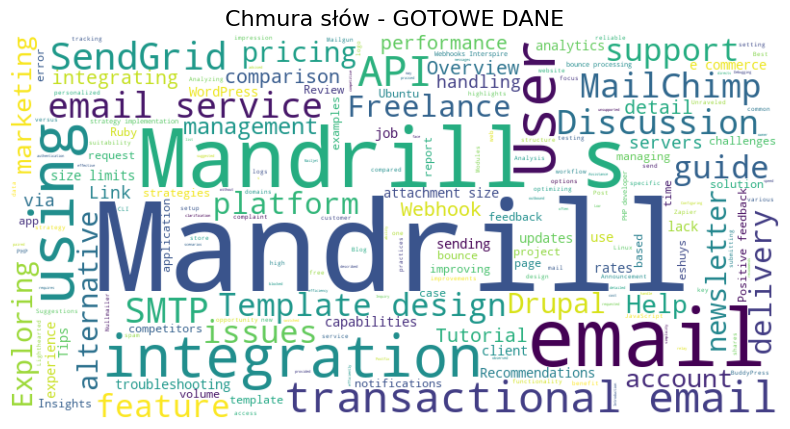

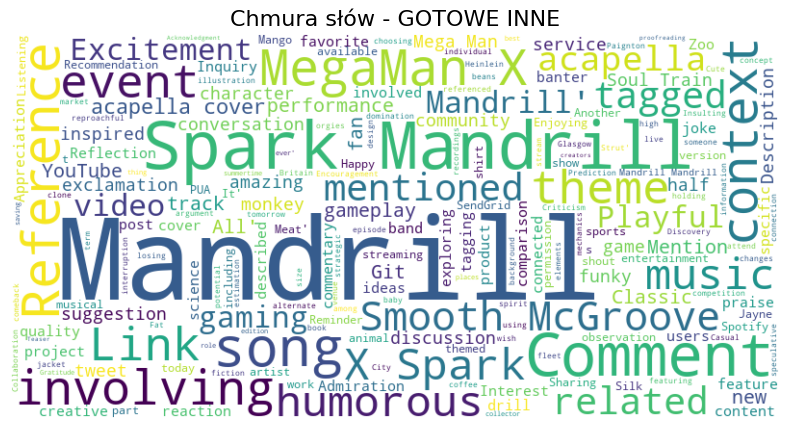

In [2]:
import pandas as pd
# openpyxl
import openpyxl
# Załaduj dane z pliku Excel
mandrill_data = pd.read_excel("Dane_3_2_Mandrill.xlsx", sheet_name="GOTOWE DANE")
other_data = pd.read_excel("Dane_3_2_Mandrill.xlsx", sheet_name="GOTOWE INNE")

# Oznacz dane etykietami
mandrill_data['label'] = 'Mandrill'
other_data['label'] = 'inne'

# Połącz dane w jeden zbiór
data = pd.concat([mandrill_data, other_data], ignore_index=True)
data = data[['Post', 'label']]  # Upewnij się, że dane mają kolumny 'Post' i 'label'

data
from sklearn.model_selection import train_test_split

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    data['Post'], data['label'], test_size=0.2, random_state=42
)

from sklearn.feature_extraction.text import TfidfVectorizer

# Przekształć dane tekstowe na wektory numeryczne
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Chmura słów
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Chmura słów dla "GOTOWE DANE"
wordcloud_dane = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(' '.join(mandrill_data['Post']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_dane, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura słów - GOTOWE DANE", fontsize=16)
plt.show()

# Chmura słów dla "GOTOWE INNE"
wordcloud_inne = WordCloud(width=800, height=400, background_color='white', stopwords=None).generate(' '.join(other_data['Post']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_inne, interpolation='bilinear')
plt.axis('off')
plt.title("Chmura słów - GOTOWE INNE", fontsize=16)
plt.show()


In [38]:
from sklearn.model_selection import train_test_split

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    data['Post'], data['label'], test_size=0.2, random_state=42
)


In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Przekształć dane tekstowe na wektory numeryczne
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Define the coordinates and values
coords_values = [
    (0, 391, 0.0722880688977364),
    (0, 482, 0.3353665249996686),
    (0, 362, 0.31482676013114486),
    (0, 724, 0.3848554625154668),
    (0, 113, 0.34838381827448234),
    (0, 80, 0.4138046351627412),
    (0, 615, 0.4138046351627412),
    (0, 753, 0.4138046351627412)
]

example_index = 132
example_post = X_train.iloc[example_index]
example_tfidf_values = X_train_tfidf[example_index]

# Print the word, coordinates, and values
for coord in coords_values:
    word = feature_names[coord[1]]
    print(f"Word: {word}, Coords: {coord[:2]}, Value: {coord[2]}")

Word: mandrill, Coords: (0, 391), Value: 0.0722880688977364
Word: platforms, Coords: (0, 482), Value: 0.3353665249996686
Word: like, Coords: (0, 362), Value: 0.31482676013114486
Word: use, Coords: (0, 724), Value: 0.3848554625154668
Word: commerce, Coords: (0, 113), Value: 0.34838381827448234
Word: cases, Coords: (0, 80), Value: 0.4138046351627412
Word: shopify, Coords: (0, 615), Value: 0.4138046351627412
Word: woocommerce, Coords: (0, 753), Value: 0.4138046351627412


In [40]:
from sklearn.naive_bayes import MultinomialNB

# Trening modelu
classifier = MultinomialNB()
classifier.fit(X_train_tfidf, y_train)


MultinomialNB()

In [41]:
from sklearn.metrics import classification_report, accuracy_score

# Przewidywanie klas na zbiorze testowym
y_pred = classifier.predict(X_test_tfidf)

# Wyświetl raport klasyfikacji
print(classification_report(y_test, y_pred))
print(f"Dokładność: {accuracy_score(y_test, y_pred):.2f}")


              precision    recall  f1-score   support

    Mandrill       0.94      0.94      0.94        31
        inne       0.93      0.93      0.93        30

    accuracy                           0.93        61
   macro avg       0.93      0.93      0.93        61
weighted avg       0.93      0.93      0.93        61

Dokładność: 0.93


179        inne
228        inne
111    Mandrill
246        inne
60     Mandrill
         ...   
249        inne
104    Mandrill
299        inne
193        inne
184        inne
Name: label, Length: 61, dtype: object
AUC po weryfikacji: 0.9817204301075269


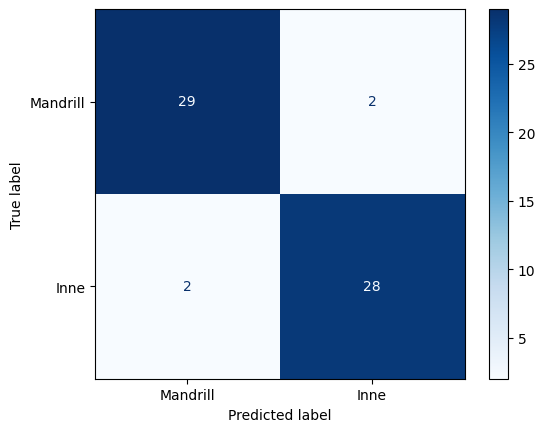

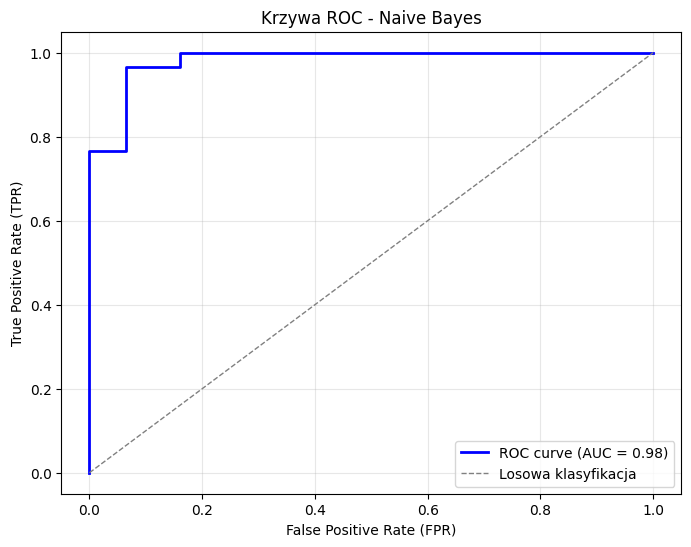

ROC  0.9817204301075269


In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, accuracy_score

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mandrill", "Inne"])
disp.plot(cmap="Blues")
# krzywa ROC
print(y_test)

from sklearn.preprocessing import LabelBinarizer

# Przekształcenie etykiet na wartości binarne
binarizer = LabelBinarizer()
y_test_binary = binarizer.fit_transform(y_test).ravel()  # Konwersja y_test na binarne
y_pred_prob = classifier.predict_proba(X_test_tfidf)[:, 1]  # Prawdopodobieństwa klasy pozytywnej

# Obliczenie metryk ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Wyświetlenie wyników
print("AUC po weryfikacji:", roc_auc)

# Wizualizacja krzywej ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Losowa klasyfikacja')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Krzywa ROC - Naive Bayes')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

print("ROC  " + str(roc_auc))

In [42]:
new_posts = [
    "The Mandrill API is great for sending personalized emails!",
    "I saw a Mandrill at the zoo today, it was fascinating!"
]

new_posts_tfidf = vectorizer.transform(new_posts)
predictions = classifier.predict(new_posts_tfidf)

for post, prediction in zip(new_posts, predictions):
    print(f"Post: {post} => Klasyfikacja: {prediction}")


Post: The Mandrill API is great for sending personalized emails! => Klasyfikacja: Mandrill
Post: I saw a Mandrill at the zoo today, it was fascinating! => Klasyfikacja: inne


In [43]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
# Tworzenie i trening modelu regresji logistycznej
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train_tfidf, y_train)




LogisticRegression(max_iter=2000, random_state=42)

In [44]:
from sklearn.metrics import roc_curve, auc, accuracy_score

# Przewidywanie klas za pomocą regresji logistycznej
y_pred_logistic = logistic_model.predict(X_test_tfidf)

# Wyświetlenie raportu klasyfikacji
print("=== Regresja Logistyczna ===")
print(classification_report(y_test, y_pred_logistic))
print(f"Dokładność: {accuracy_score(y_test, y_pred_logistic):.2f}")

# krzywa ROC


=== Regresja Logistyczna ===
              precision    recall  f1-score   support

    Mandrill       0.97      0.90      0.93        31
        inne       0.91      0.97      0.94        30

    accuracy                           0.93        61
   macro avg       0.94      0.93      0.93        61
weighted avg       0.94      0.93      0.93        61

Dokładność: 0.93


In [45]:
print("=== Porównanie ===")
print("Naive Bayes:")
print(f"Dokładność: {accuracy_score(y_test, y_pred):.2f}")
print("\nRegresja Logistyczna:")
print(f"Dokładność: {accuracy_score(y_test, y_pred_logistic):.2f}")


=== Porównanie ===
Naive Bayes:
Dokładność: 0.93

Regresja Logistyczna:
Dokładność: 0.93


In [46]:
# Przewidywanie nowych postów
logistic_predictions = logistic_model.predict(new_posts_tfidf)

for post, prediction in zip(new_posts, logistic_predictions):
    print(f"Post: {post} => Klasyfikacja (Regresja Logistyczna): {prediction}")


Post: The Mandrill API is great for sending personalized emails! => Klasyfikacja (Regresja Logistyczna): Mandrill
Post: I saw a Mandrill at the zoo today, it was fascinating! => Klasyfikacja (Regresja Logistyczna): inne


179        inne
228        inne
111    Mandrill
246        inne
60     Mandrill
         ...   
249        inne
104    Mandrill
299        inne
193        inne
184        inne
Name: label, Length: 61, dtype: object


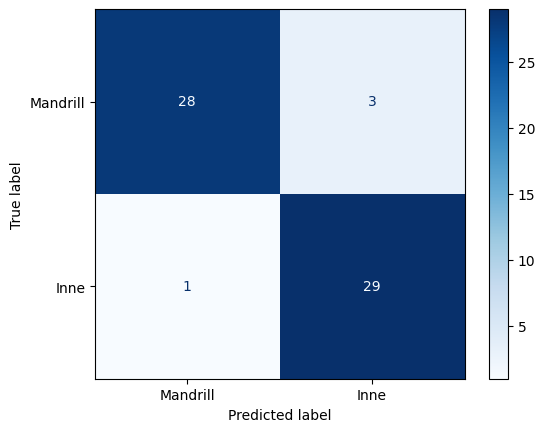

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred_logistic)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mandrill", "Inne"])
disp.plot(cmap="Blues")
# krzywa ROC
print(y_test)


AUC po weryfikacji: 0.9774193548387096


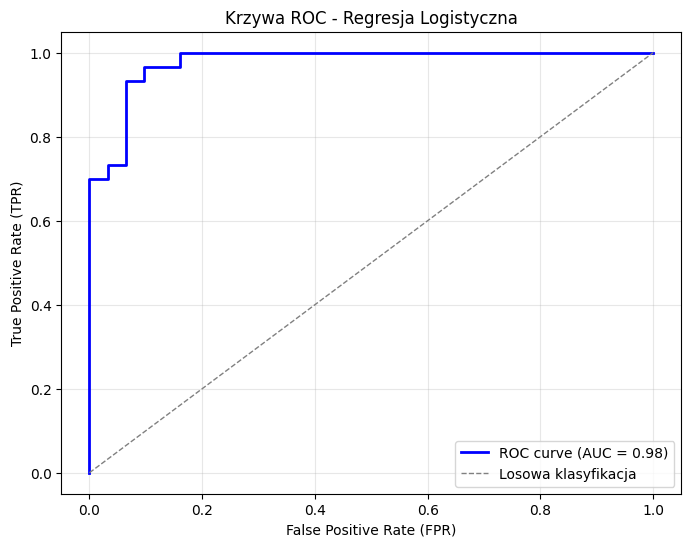

In [48]:
from sklearn.preprocessing import LabelBinarizer

# Przekształcenie etykiet na wartości binarne
binarizer = LabelBinarizer()
y_test_binary = binarizer.fit_transform(y_test).ravel()  # Konwersja y_test na binarne
y_pred_prob_logistic = logistic_model.predict_proba(X_test_tfidf)[:, 1]  # Prawdopodobieństwa klasy pozytywnej

# Obliczenie metryk ROC
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_prob_logistic)
roc_auc = auc(fpr, tpr)

# Wyświetlenie wyników
print("AUC po weryfikacji:", roc_auc)

# Wizualizacja krzywej ROC
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Losowa klasyfikacja')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Krzywa ROC - Regresja Logistyczna')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


In [49]:
# wyswietls słowa najbardziej zwiazane z mandrill
# Pobierz współczynniki modelu regresji logistycznej
# Pobierz współczynniki modelu regresji logistycznej
logistic_coefs = logistic_model.coef_[0]

# Posortuj współczynniki i pobierz indeksy
sorted_indices = logistic_coefs.argsort()

# Pobierz 10 słów najbardziej związanych z klasą 'Mandrill'
top_n = 10
top_positive_words = [feature_names[i] for i in sorted_indices[-top_n:]]
top_negative_words = [feature_names[i] for i in sorted_indices[:top_n]]

print("Słowa najbardziej związane z klasą 'Mandrill':")
for word in top_positive_words:
    print(word)

print("\nSłowa najbardziej związane z klasą 'inne':")
for word in top_negative_words:
    print(word)

# posty źle sklasyfikowane
# Pobierz indeksy postów źle sklasyfikowanych
misclassified_indices = y_test[y_test != y_pred_logistic].index

# Pobierz posty źle sklasyfikowane
misclassified_posts = X_test.loc[misclassified_indices]

# Wyświetl posty
for post in misclassified_posts:
    print(post)

Słowa najbardziej związane z klasą 'Mandrill':
humorous
megaman
related
music
context
spark
involving
reference
song
comment

Słowa najbardziej związane z klasą 'inne':
email
integration
api
using
template
user
transactional
pricing
emails
smtp
Considering the feasibility of Mandrill for specific use cases.
Discussion on Mandrill's comeback and performance.
Reference to Mandrill in a lighthearted jungle analogy.
JavaScript arrays as a solution in a Mandrill-related problem.
